# OECD - International comparisons - new API

https://data-explorer.oecd.org/?lc=en

## Python setup

In [1]:
# system imports
from io import StringIO
from pathlib import Path
from typing import Any, Sequence, cast
import time

In [2]:
# analytic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# local imports
import common
import plotting as pg

In [4]:
# plotting stuff
plt.style.use("fivethirtyeight")
TARGET = {
    "ymin": 2,
    "ymax": 3,
    "color": "#dddddd",
    "label": "2-3% inflation target",
    "zorder": -1,
}
TARGET_V = TARGET | {"xmin": 2, "xmax": 3}
del TARGET_V["ymax"]
del TARGET_V["ymin"]

# Where to put the charts
CHART_DIR = "./CHARTS/OECD/"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
pg.set_chart_dir(CHART_DIR)

# Remove old charts
for filename in Path(CHART_DIR).glob("*.png"):
    filename.unlink()

# display charts in notebook
SHOW = True

## Utility functions for OECD data capture

In [5]:
location_map = {
    "AUS": "Australia",
    "AUT": "Austria",
    "BEL": "Belgium",
    "CAN": "Canada",
    "CHL": "Chile",
    "CZE": "Czech Rep.",
    "DNK": "Denmark",
    "EST": "Estonia",
    "FIN": "Finland",
    "FRA": "France",
    "DEU": "Germany",
    "GRC": "Greece",
    "HUN": "Hungary",
    "ISL": "Iceland",
    "IRL": "Ireland",
    "ISR": "Israel",
    "ITA": "Italy",
    "JPN": "Japan",
    "KOR": "Korea",
    "LVA": "Latvia",
    "LUX": "Luxembourg",
    "MEX": "Mexico",
    "NLD": "Netherlands",
    "NZL": "New Zealand",
    "NOR": "Norway",
    "POL": "Poland",
    "PRT": "Portugal",
    "SVK": "Slovak Rep.",
    "SVN": "Slovenia",
    "ESP": "Spain",
    "SWE": "Sweden",
    "CHE": "Switzerland",
    "TUR": "Türkiye",
    "GBR": "United Kingdom",
    "USA": "United States",
    "ARG": "Argentina",
    "BRA": "Brazil",
    "CHN": "China",
    "COL": "Colombia",
    "CRI": "Costa Rica",
    "IND": "India",
    "IDN": "Indonesia",
    "LTU": "Lithuania",
    "RUS": "Russia",
    "SAU": "Saudi Arabia",
    "ZAF": "South Africa",
    "ROU": "Romania",
    "BGR": "Bulgaria",
    "HRV": "Croatia",
}

In [6]:
def get_oecd_table(
    agency: str, dataflow: str, filter_expr: str, options: str
) -> pd.DataFrame:
    """Capture a DataFrame from the OECD data API.
    OECD updated data API:
        https://sdmx.oecd.org/public/rest/data/
        <agency identifier>,<dataflow identifier>,<dataflow version>/
        <filter expression>[?<optional parameters>]

    Use https://data-explorer.oecd.org/?lc=en
    to get the necessary identifiers."""

    stem = "https://sdmx.oecd.org/public/rest/data"
    options = options + "&format=csv"
    options = options[1:] if options[0] == "&" else options

    url = f"{stem}/{agency},{dataflow}/{filter_expr}?{options}"
    contents = common.request_get(url).decode("utf-8")
    df = pd.read_csv(StringIO(contents))
    pvt = df.pivot(index="TIME_PERIOD", columns="REF_AREA", values="OBS_VALUE")

    pvt = pvt.dropna(how="all", axis=1)
    pvt = pvt.dropna(how="all", axis=0)

    return pvt


SOURCE = "OECD Data Explorer"

In [7]:
def check_missing(df: pd.DataFrame) -> None:
    """Check data downloaded from OECD for missing columns."""

    # external check:
    missing = list(set(location_map.keys()) - set(df.columns))
    if missing:
        text = ", ".join([location_map[x] for x in missing])
        print(f"Missing national data for {text}")

    # internal check
    final_row = df.iloc[-1]
    missing_count = final_row.isna().sum()
    if missing_count:
        print(f"Final period: {final_row.name}")
        print(f"Missing data count for final period: {missing_count}")
        print(f"Missing data belongs to: {df.columns[final_row.isna()].to_list()}")
        print(f"Nations with final data: {df.columns[final_row.notna()].to_list()}")

In [8]:
def remove_non_national(df: pd.DataFrame) -> pd.DataFrame:
    """Remove non-national columns."""

    remove = df.columns.difference(location_map.keys())
    if len(remove):
        print(f"Removing columns: {remove}")
        df = df.drop(remove, axis=1)
    return df

In [9]:
def combine(left: None | pd.DataFrame, right: pd.DataFrame) -> pd.DataFrame:
    """Concatenate two DataFrames horizontally.
    Ignore columns in right that we already have in left.
    Therefore you need to capture the most relevant dataflows first.
    Used when we need combine get data from multiple OECD tables."""

    if left is None:
        left = right
    else:
        duplicates = left.columns.intersection(right.columns)
        if len(duplicates):
            right = right.drop(duplicates, axis=1)
        left = pd.concat([left, right], axis=1)

    return left

In [10]:
def fix_monthly(df: pd.DataFrame) -> pd.DataFrame:
    """Fix quarterly data as monthly. Note, where the OECD places
    quarterly data in a monthly series, it places this data in the
    mid-quarter month. So we will replicate with the conversion of
    quarterly fsts to monthly."""

    df.index += 1  # mid-period
    index = pd.period_range(start=df.index.min(), end=df.index.max())
    df = df.reindex(index)
    df = df.interpolate(limit_area="inside", limit=2, axis=0)
    return df

In [11]:
WEB_DELAY = 2  # seconds

## Utility functions for plotting

In [12]:
def get_chart_groups() -> dict[str, list[str]]:
    """Get chart groups, with no more than 6 lines
    per chart."""

    of_interest = ["AUS", "USA", "CAN", "DEU", "GBR", "JPN"]
    anglosphere = ["AUS", "USA", "CAN", "NZL", "GBR", "IRL"]
    major_europe = ["FRA", "DEU", "ITA", "GBR", "RUS", "ESP"]
    largest_economies = ["USA", "CHN", "JPN", "DEU", "GBR", "IND"]
    asia = ["KOR", "JPN", "CHN", "IND", "IDN"]
    north_europe = ["DNK", "SWE", "NOR", "ISL", "FIN", "GBR"]
    baltic_europe = ["LVA", "LTU", "EST"]
    central_europe = ["CZE", "HUN", "SVK", "SVN", "POL", "GRC"]
    west_europe = ["BEL", "ESP", "PRT", "NLD", "LUX", "FRA"]
    italo_germanic_europe = ["DEU", "AUT", "CHE", "ITA"]
    n_america = ["USA", "CAN", "MEX"]
    c_s_america = ["CHL", "BRA", "COL", "CRI"]
    other = ["AUS", "NZL", "SAU", "ZAF", "ISR"]
    high_inflation = [
        "TUR",
        "ARG",
    ]

    charts = {
        "of_interest": of_interest,
        "anglosphere": anglosphere,
        "major_europe": major_europe,
        "largest_economies": largest_economies,
        "asia": asia,
        "north_europe": north_europe,
        "baltic_europe": baltic_europe,
        "central_europe": central_europe,
        "west_europe": west_europe,
        "italo_germanic_europe": italo_germanic_europe,
        "n_america": n_america,
        "c_s_america": c_s_america,
        "high_inflation": high_inflation,
        "other": other,
    }

    return charts


chart_sets = get_chart_groups()

In [13]:
PW_COUNTER = 0  # global filename suffix - I know, ugly.

In [14]:
def plot_world(
    data: pd.DataFrame,
    exclusions: None | list[str] = None,
    **kwargs: Any,
) -> None:
    """Plot Australia vs the OECD monitored mean and median."""

    # Exclude problematic OECD states
    data = data.rename(columns=location_map)
    if exclusions is not None:
        for c in exclusions:
            if c in data.columns:
                data = data.drop(c, axis=1)

    # plot remaining OECD states without legend label using the _ trick
    mapper = {x: f"_{x}" for x in data.columns}
    data = data.rename(columns=mapper)
    ax = data.plot(color="blue", lw=0.25, alpha=0.5)
    back = {y: x for x, y in mapper.items()}
    data = data.rename(columns=back)

    # plot mean if THRESHOLD proportion of non-na data points met
    threshold = 0.75
    mean = data.mean(axis=1).where(
        data.notna().sum(axis=1) >= len(data.columns) * threshold,
        other=np.nan,
    )
    median = data.median(axis=1).where(
        data.notna().sum(axis=1) >= len(data.columns) * threshold,
        other=np.nan,
    )
    mean.plot(ax=ax, color="darkblue", ls="--", lw=2, label="OECD mean")
    median.plot(ax=ax, color="darkred", ls=":", lw=2, label="OECD median")

    # plot
    data["Australia"].dropna().plot(ax=ax, color="darkorange", lw=3, label="Australia")
    global PW_COUNTER  # yes, this is ugly
    PW_COUNTER = PW_COUNTER + 1
    pg.finalise_plot(
        ax,
        xlabel=None,
        y0=True,
        rfooter=SOURCE,
        tag=str(PW_COUNTER),
        legend={"loc": "best", "fontsize": "xx-small"},
        **kwargs,
        show=SHOW,
    )

In [15]:
def plot_annual(data: pd.DataFrame, **kwargs: Any) -> None:
    """Quick Annual Charts, based on chart_sets from above."""

    for tag, chart_set in chart_sets.items():
        chart_set = sorted(set(chart_set).intersection(set(data.columns)))
        cs = data[chart_set].rename(columns=location_map)
        pg.line_plot(
            cs,
            tags=tag,
            xlabel=None,
            dropna=True,
            y0=True,
            width=2,
            rfooter=SOURCE,
            **kwargs,
            show=SHOW,
        )

## Unemployment rate

In [16]:
def get_ue_data():
    """Get OECD unemployment rate data.
    Challenge: NZL and CHE only reported quarterly."""

    agency = "OECD.SDD.TPS"
    dataflow = "DSD_LFS@DF_IALFS_UNE_M,1.0"
    filter_exprs = (
        "..._Z.Y._T.Y_GE15..M",  # get monthly data first
        "..._Z.Y._T.Y_GE15..Q",  # then get quarterly
    )
    options = "startPeriod=2000-01"

    combined = None
    for filter_expr in filter_exprs:
        ue = get_oecd_table(agency, dataflow, filter_expr, options)
        ue.index = pd.PeriodIndex(ue.index, freq="M")
        if filter_expr[-1] == "Q":
            ue = fix_monthly(ue)
        combined = combine(combined, ue)
        time.sleep(WEB_DELAY)  # be nice to the OECD server

    return remove_non_national(combined)


ue_rates = get_ue_data()

Removing columns: Index(['EA20', 'EU27_2020', 'G7', 'OECD'], dtype='object', name='REF_AREA')


In [17]:
check_missing(ue_rates)

Missing national data for Brazil, Argentina, South Africa, Bulgaria, Croatia, Romania, Russia, India, Saudi Arabia, China, Indonesia
Final period: 2024-02
Missing data count for final period: 32
Missing data belongs to: ['AUS', 'AUT', 'BEL', 'CHL', 'COL', 'CRI', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IRL', 'ISL', 'ITA', 'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR', 'POL', 'PRT', 'SVK', 'SVN', 'SWE', 'TUR', 'NZL']
Nations with final data: ['CAN', 'ISR', 'JPN', 'KOR', 'USA', 'CHE']


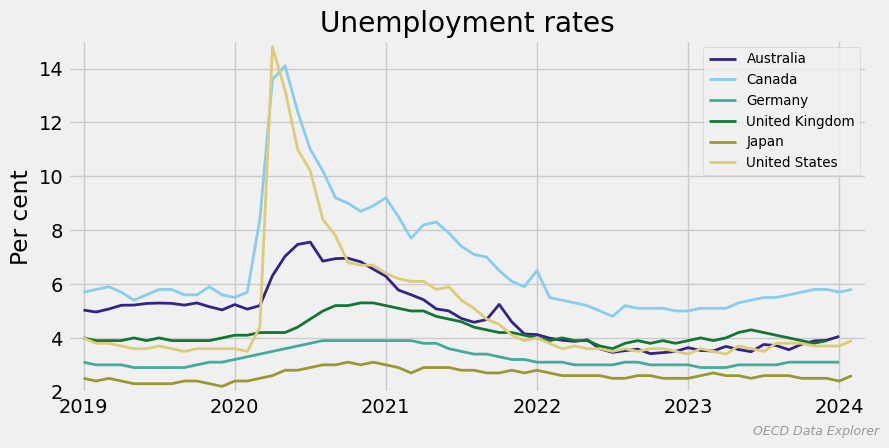

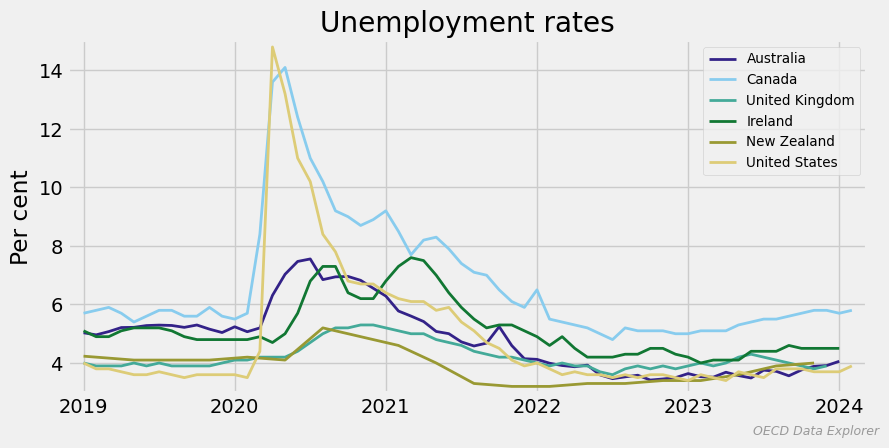

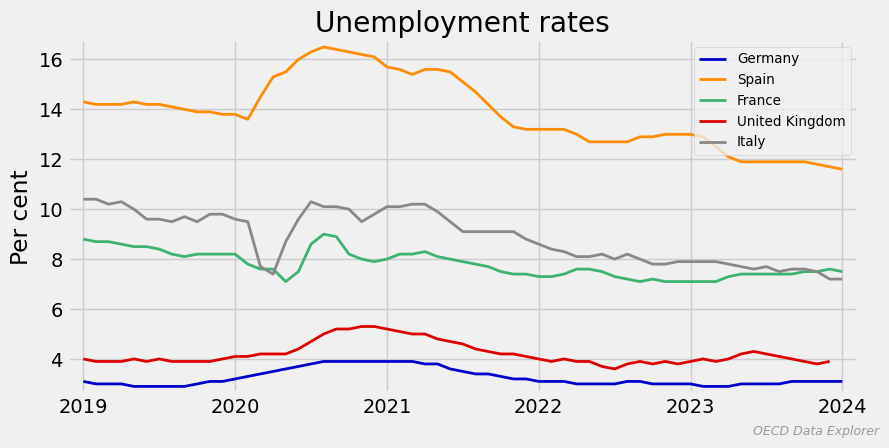

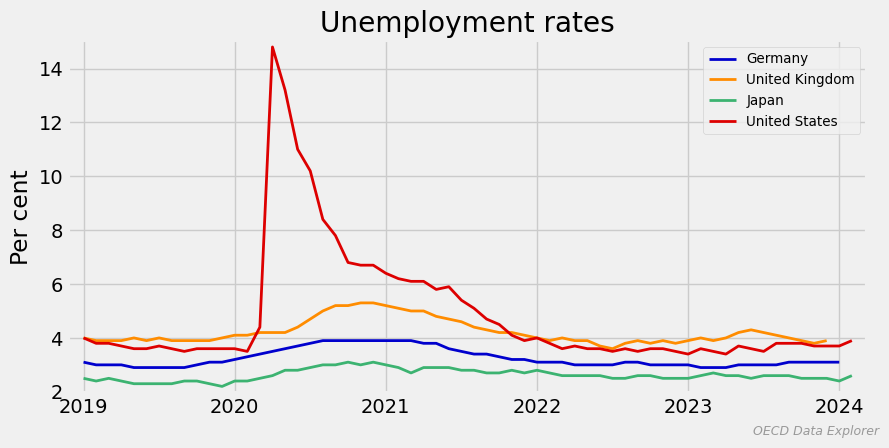

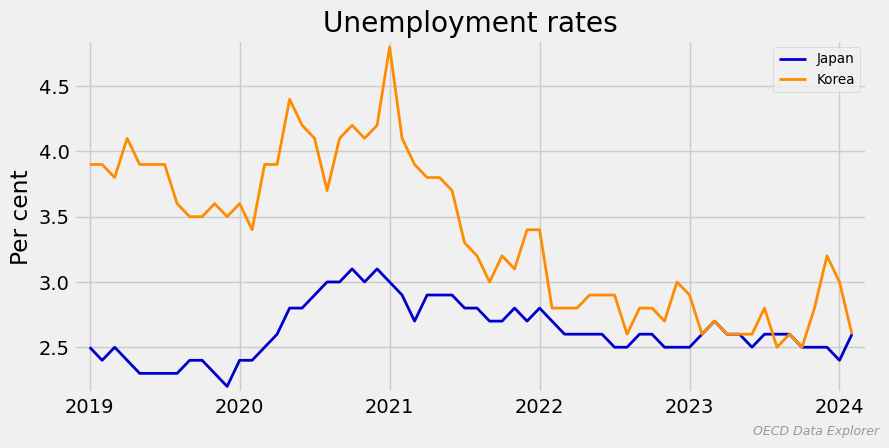

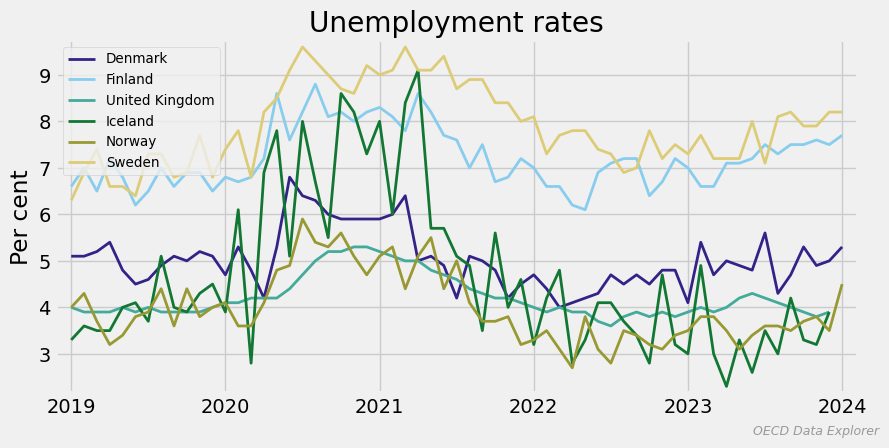

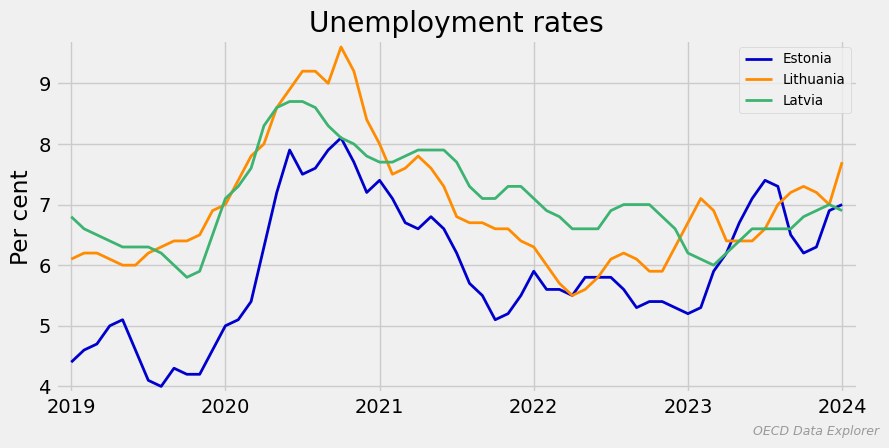

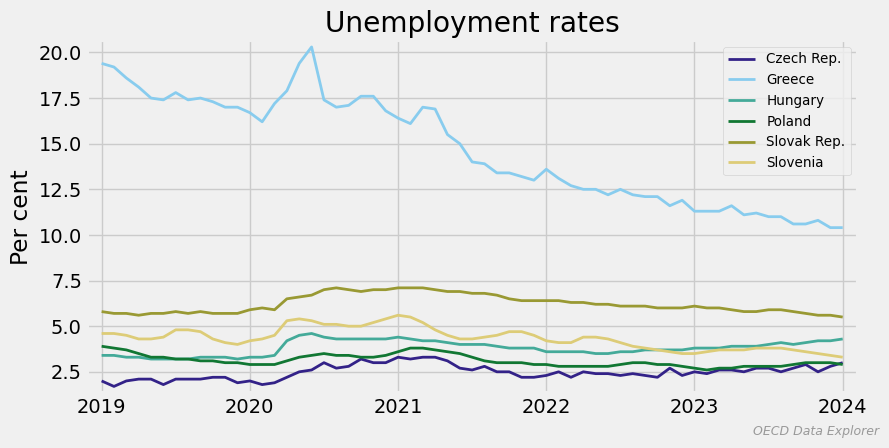

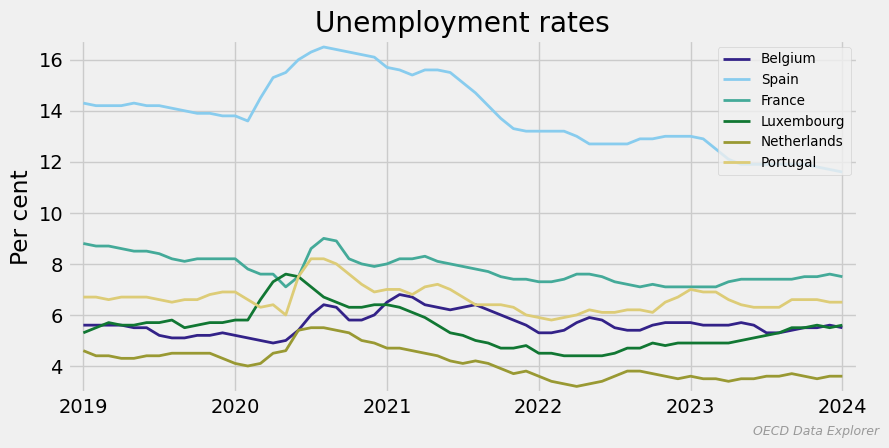

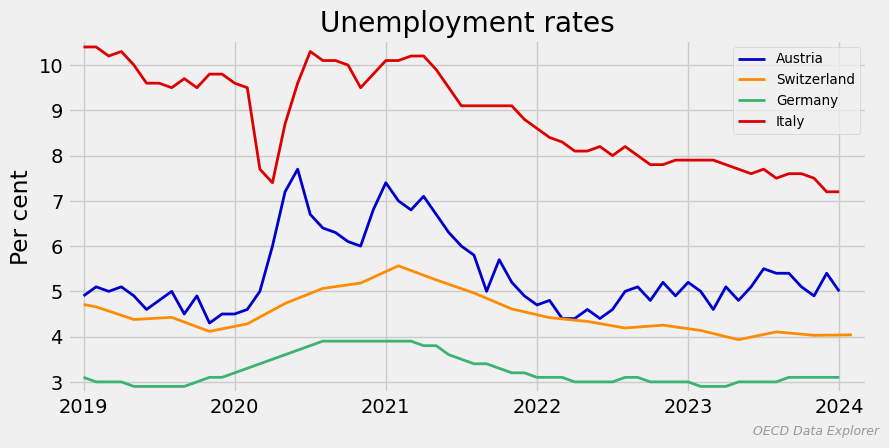

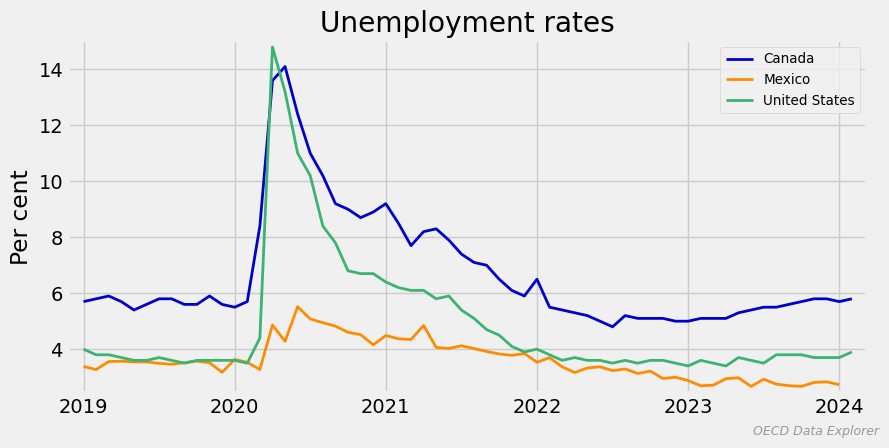

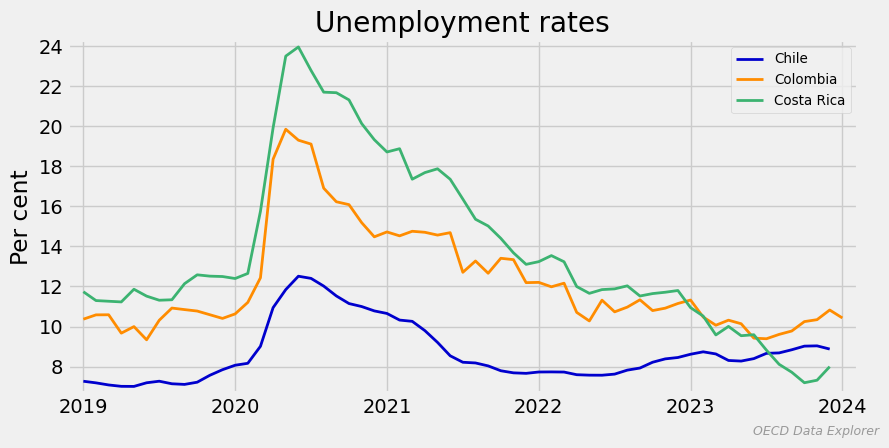

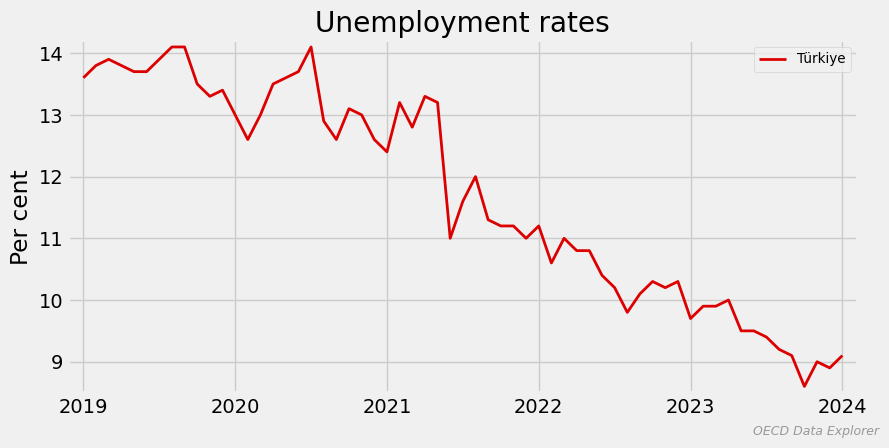

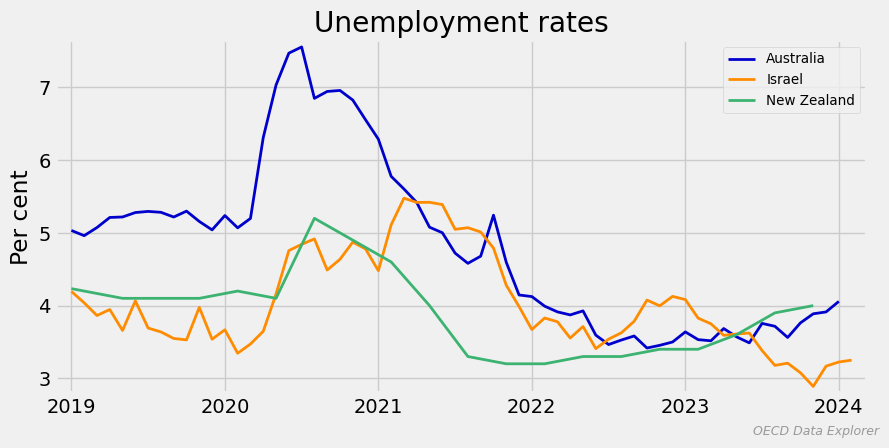

In [18]:
def plot_ue(data: pd.DataFrame) -> None:
    """Plot unemployment rate data."""

    kwargs: dict[str, Any] = {
        "title": "Unemployment rates",
        "ylabel": "Per cent",
        "legend": {"loc": "best", "fontsize": "x-small"},
    }
    plot_annual(data, **kwargs)


plot_ue(ue_rates[ue_rates.index.year >= 2019])

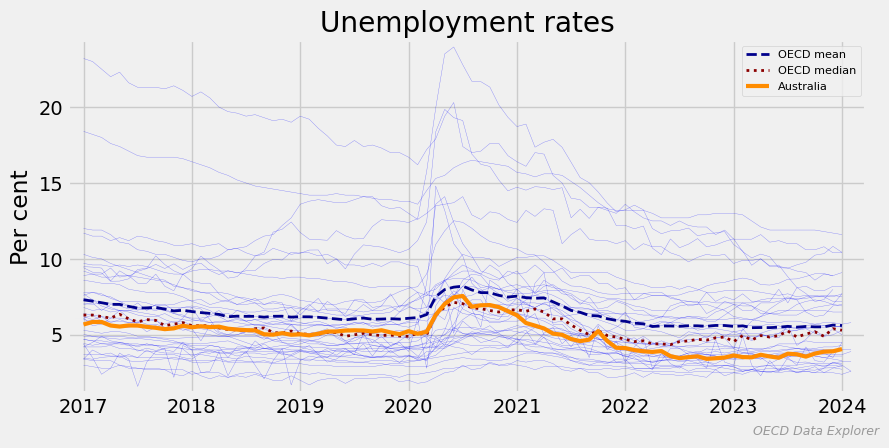

In [19]:
def plot_world_ue() -> None:
    "Plot comparative unemployment rates."

    kwargs: dict[str, Any] = {
        "title": "Unemployment rates",
        "ylabel": "Per cent",
    }
    plot_world(ue_rates[ue_rates.index.year >= 2017], **kwargs)


plot_world_ue()

## GDP

Chain linked volume measures, national currency, seasonally adjusted

In [20]:
def get_real_gdp_qtly_growth():
    """Get real GDP (national currency / seasonally adjusted),
    and return quarterly growth."""

    agency = "OECD.SDD.NAD"
    dataflow = "DSD_NAMAIN1@DF_QNA_EXPENDITURE_NATIO_CURR,1.0"
    filter_expr = "Q.Y....B1GQ.....L.."
    options = "startPeriod=1999-Q4&dimensionAtObservation=AllDimensions"

    rgdp = get_oecd_table(agency, dataflow, filter_expr, options)
    rgdp.index = pd.PeriodIndex(rgdp.index, freq="Q")
    rgdp = remove_non_national(rgdp)
    growth = (rgdp.pct_change(fill_method=None) * 100).dropna(how="all")

    return growth


gdp = get_real_gdp_qtly_growth()
check_missing(gdp)

Removing columns: Index(['EA20', 'EU27_2020'], dtype='object', name='REF_AREA')
Missing national data for Argentina, South Africa, Mexico, India, China, Indonesia
Final period: 2023Q4
Missing data count for final period: 1
Missing data belongs to: ['RUS']
Nations with final data: ['AUS', 'AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHL', 'COL', 'CRI', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL', 'ISL', 'ISR', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA', 'NLD', 'NOR', 'NZL', 'POL', 'PRT', 'ROU', 'SAU', 'SVK', 'SVN', 'SWE', 'TUR', 'USA']


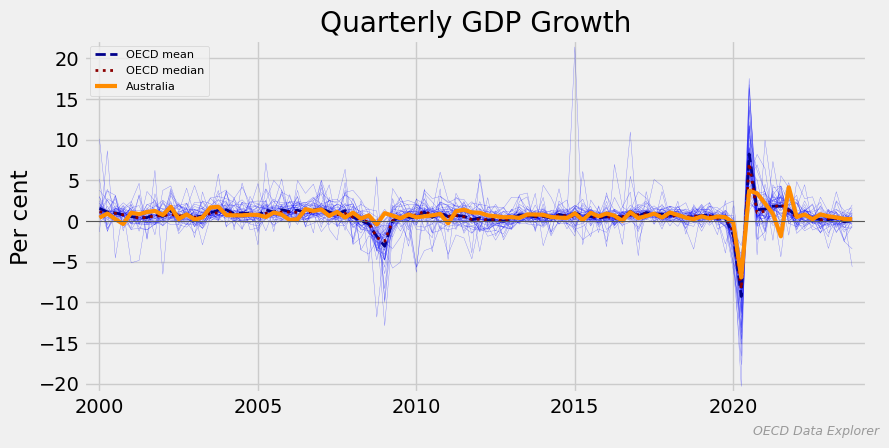

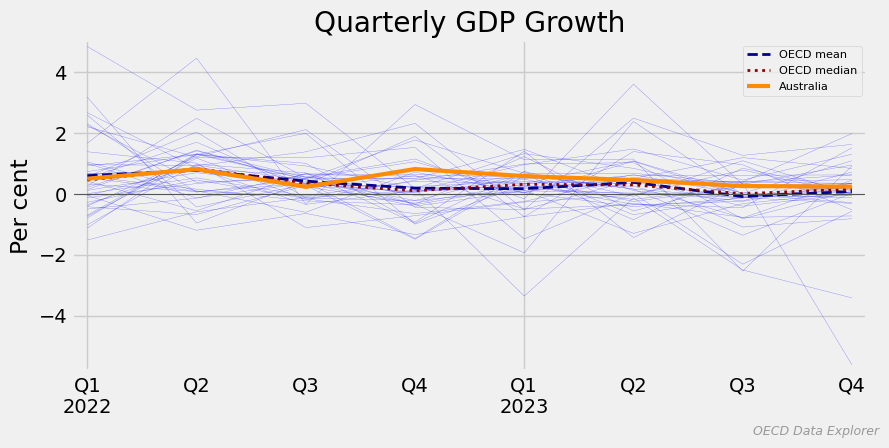

In [21]:
def plot_world_gdp() -> None:
    "Plot world GDP."

    kwargs: dict[str, Any] = {"title": "Quarterly GDP Growth", "ylabel": "Per cent"}
    plot_world(gdp, **kwargs)
    plot_world(gdp[gdp.index.year >= 2022], **kwargs)


plot_world_gdp()

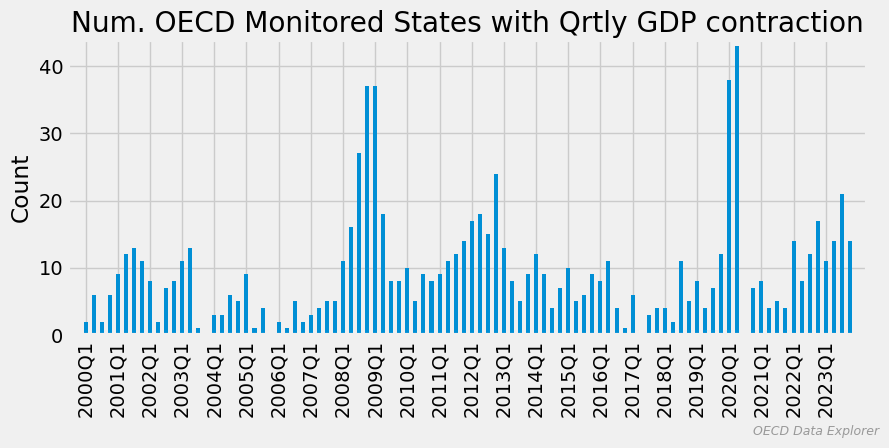

Latest nations in contraction, N=14
Brazil, Germany, Estonia, Finland, United Kingdom, Hungary, Ireland, Israel, Lithuania, New Zealand, Poland, Romania, Saudi Arabia, Sweden


In [22]:
def plot_contractions(growth: pd.DataFrame):
    """GDP identify/count quarterly contractions."""

    contractions = growth < 0
    contraction_count = contractions.sum(axis=1)

    start = pd.Period("2000Q1", freq="Q")
    title = "Num. OECD Monitored States with Qrtly GDP contraction"

    ax = contraction_count[contraction_count.index >= start].plot.bar()
    ax.set_xticks(ax.get_xticks()[::4])
    pg.finalise_plot(
        ax,
        title=title,
        ylabel="Count",
        rfooter=SOURCE,
        show=SHOW,
    )

    # print nations in contraction
    print(f"Latest nations in contraction, N={contraction_count.iloc[-1]}")
    print(
        ", ".join(
            [
                location_map[x]
                for x in contractions.iloc[-1][contractions.iloc[-1]].index
            ]
        )
    )


plot_contractions(gdp)

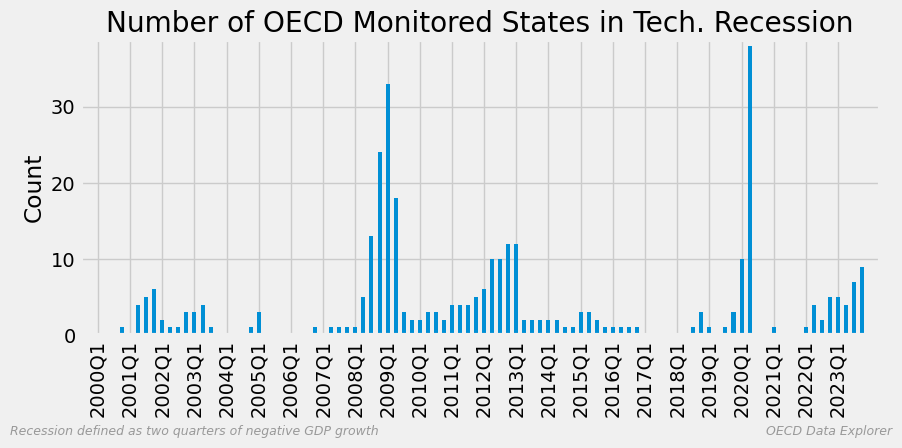

Latest N=9
Germany, Estonia, Finland, United Kingdom, Ireland, Lithuania, New Zealand, Saudi Arabia, Sweden


In [23]:
def plot_recessions(growth: pd.DataFrame):
    """GDP identify/count technical recessions."""

    recessions = (growth < 0) & (growth.shift(1) < 0)
    recession_count = recessions.sum(axis=1)

    title = "Number of OECD Monitored States in Tech. Recession"
    start = pd.Period("2000Q1", freq="Q")
    ax = recession_count[recession_count.index >= start].plot.bar()
    ax.set_xticks(ax.get_xticks()[::4])
    pg.finalise_plot(
        ax,
        title=title,
        ylabel="Count",
        rfooter=SOURCE,
        lfooter="Recession defined as two quarters of negative GDP growth",
        show=SHOW,
    )

    # print nations in contraction
    print(f"Latest N={recession_count.iloc[-1]}")
    print(
        ", ".join(
            [location_map[x] for x in recessions.iloc[-1][recessions.iloc[-1]].index]
        )
    )


plot_recessions(gdp)

## Inflation 

In [24]:
EXCLUDE = ["Türkiye", "Russia", "Argentina"]
# Turkey and Argentina have rampant inflation
# Russia not updating data during war

In [25]:
def get_annual_inflation() -> pd.DataFrame:
    """Get OECD Annual Inflation Data.

    The challenges:
    - two different dataflows,
    - while most nations report monthly, some report quarterly, and
    - Australia, which reports quarterly, is included in the monthly data,
      but New Zealand is not."""

    agency = "OECD.SDD.TPS"
    dataflows = (
        "DSD_PRICES_COICOP2018@DF_PRICES_C2018_ALL,1.0",  # must be first
        "DSD_PRICES@DF_PRICES_ALL,1.0",
    )
    filter_exprs = (
        ".M.N.CPI.PA._T.N.GY",  # Monthly must be first
        ".Q.N.CPI.PA._T.N.GY",
    )

    options = "startPeriod=2019-07"

    combined = None
    for dataflow in dataflows:
        for filter_expr in filter_exprs:
            pvt = get_oecd_table(agency, dataflow, filter_expr, options)
            pvt.index = pd.PeriodIndex(pvt.index, freq="M")
            if filter_expr[1] == "Q":
                pvt = fix_monthly(pvt)
            combined = combine(combined, pvt)
            time.sleep(WEB_DELAY)  # just to be nice to the server.

    return remove_non_national(cast(pd.DataFrame, combined))


annual_inflation = get_annual_inflation()

Removing columns: Index(['EA20', 'EU27_2020', 'G20', 'G7', 'OECD', 'OECDE'], dtype='object', name='REF_AREA')


In [26]:
check_missing(annual_inflation)

Missing national data for Bulgaria, Croatia, Romania
Final period: 2024-03
Missing data count for final period: 45
Missing data belongs to: ['CHL', 'CRI', 'JPN', 'ARG', 'AUS', 'AUT', 'BEL', 'BRA', 'CAN', 'CHE', 'CHN', 'COL', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IDN', 'IND', 'IRL', 'ISR', 'ITA', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR', 'POL', 'PRT', 'RUS', 'SAU', 'SVK', 'SVN', 'SWE', 'TUR', 'USA', 'ZAF', 'NZL']
Nations with final data: ['ISL']


In [27]:
def get_recent_ohlc(data: pd.DataFrame) -> pd.DataFrame:
    """For a dataset, build a table of Open, Highm Low, Close
    points for last valid 13 months in each column."""

    # compare progress over 13 months because Australia
    # and New Zealand only collect CPI measures quarterly
    inclusive_year = 13  # months
    index = ["Open", "High", "Low", "Close"]
    summary = pd.DataFrame([], index=index)  # return vehicle
    for name in data.columns:
        if name in EXCLUDE:
            continue
        column = data[name]
        last_valid = cast(pd.Period, column.last_valid_index())  # mypy cast
        year = pd.period_range(end=last_valid, periods=inclusive_year)
        frame = column[year]
        open_ = frame.iloc[0]
        high = frame.max()
        low = frame.min()
        close = frame.iloc[-1]
        key = f"{name} {str(last_valid.year)[2:]}-{last_valid.month:02d}"
        summary[key] = pd.Series([open_, high, low, close], index=index)
    summary = summary.T.sort_values("Close")
    return summary

In [28]:
def plot_ohlc(ohlc_df: pd.DataFrame, horizontal: bool = True, **kwargs: Any) -> None:
    """Plot data in ohlc_df in a open-high-low-close style."""

    def xy(x, y):
        return (x, y) if horizontal else (y, x)

    def set_limits(ax: plt.Axes) -> None:
        minimum = min(0, ohlc_df["Low"].min())  # include zero
        maximum = ohlc_df["High"].max()
        adjustment = (maximum - minimum) * 0.025
        limits = minimum - adjustment, maximum + adjustment
        if horizontal:
            ax.set_xlim(*limits)
        else:
            ax.set_ylim(*limits)

    # canvass
    _, ax = plt.subplots()

    # sort out chart orientation
    good, bad = "darkblue", "darkorange"  # for colour blindness
    bar_method = ax.barh if horizontal else ax.bar
    reference = "left" if horizontal else "bottom"
    range_ = ohlc_df["High"] - ohlc_df["Low"]
    open_marker = "^" if horizontal else "<"
    close_marker = "v" if horizontal else ">"
    color = [
        good if open > close else bad
        for open, close in zip(ohlc_df.Open, ohlc_df.Close)
    ]

    # plot
    bar_method(
        ohlc_df.index,
        range_,
        **{reference: ohlc_df["Low"]},
        color=color,
        linewidth=1.0,
        edgecolor="black",
        label="Range of prints through the 13 months",
        alpha=0.15,
    )
    ax.plot(
        *xy(ohlc_df["Open"], ohlc_df.index),
        marker=open_marker,
        linestyle="None",
        label="First print in the 13 months",
        color=good,
        markersize=5,
    )
    ax.plot(
        *xy(ohlc_df["Close"], ohlc_df.index),
        marker=close_marker,
        linestyle="None",
        label="Last print in the 13 months",
        color=bad,
        markersize=5,
    )
    ax.tick_params(axis="both", which="major", labelsize="x-small")
    set_limits(ax=ax)
    if not horizontal:
        ax.set_xticklabels(ohlc_df.index, rotation=90)
    pg.finalise_plot(ax, **kwargs)

In [29]:
def get_lim(df):
    """Get the limits of the data plus some wriggle room."""

    adjust = (df["High"].max() - df["Low"].min()) * 0.02
    return min(0, df["Low"].min()) - adjust, df["High"].max() + adjust

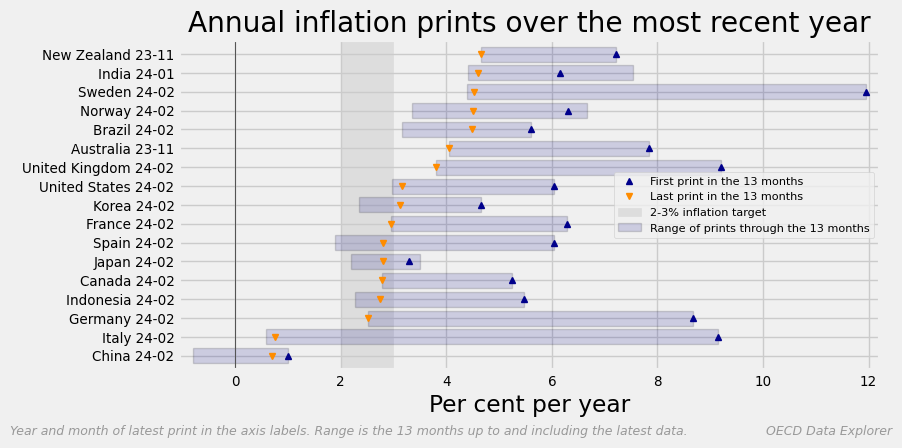

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_85940/398792555.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ohlc_df.index, rotation=90)


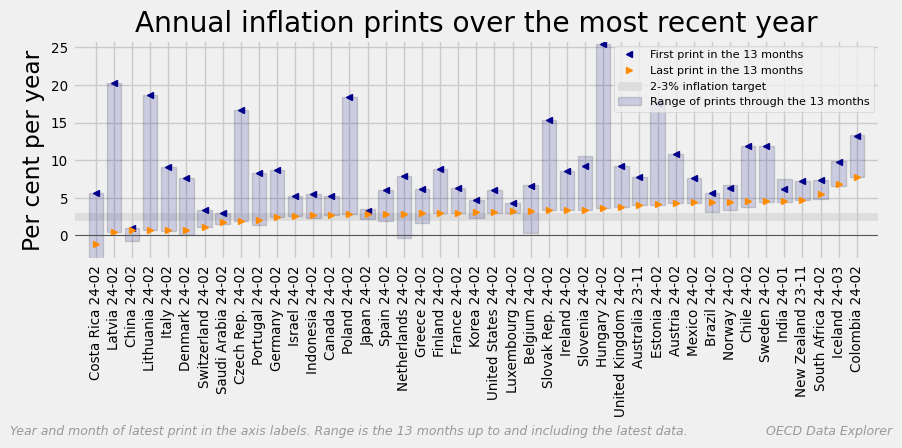

In [30]:
class InflationPlotter:
    """Plots recent inflation range for selected nations."""

    plot_count = 0

    def plot_selected(self, nations: Sequence, horizontal: bool) -> None:
        """Plot of Inflation over the [ast year - selected nations."""

        inflation = annual_inflation.rename(columns=location_map)
        columns = inflation.columns.intersection(nations)
        summary = get_recent_ohlc(inflation[columns])

        title_aip = "Annual inflation prints over the most recent year"
        lfooter = (
            "Year and month of latest print in the axis labels. "
            "Range is the 13 months up to and including the latest data. "
        )
        plot_ohlc(
            summary,
            horizontal=horizontal,
            title=title_aip,
            xlim=get_lim(summary) if horizontal else None,
            zero_y=horizontal,
            xlabel="Per cent per year" if horizontal else None,
            ylabel="Per cent per year" if not horizontal else None,
            tag=str(InflationPlotter.plot_count),
            axvspan=TARGET_V if horizontal else None,
            axhspan=TARGET if not horizontal else None,
            y0=not horizontal,
            x0=horizontal,
            legend={"loc": "best", "fontsize": "xx-small"},
            rfooter=SOURCE,
            lfooter=lfooter,
            show=SHOW,
        )
        InflationPlotter.plot_count += 1


horizontal_set = (
    "Australia",
    "Canada",
    "China",
    "France",
    "Germany",
    "India",
    "Indonesia",
    "Italy",
    "Japan",
    "Korea",
    "United Kingdom",
    "United States",
    "New Zealand",
    "Norway",
    "Sweden",
    "Brazil",
    "Spain",
)
ip = InflationPlotter()
ip.plot_selected(
    nations=horizontal_set,
    horizontal=True,
)

all_nations = [
    location_map[x]
    for x in annual_inflation.columns
    if x in location_map and x != "ARG"
]
ip.plot_selected(all_nations, horizontal=False)
del ip

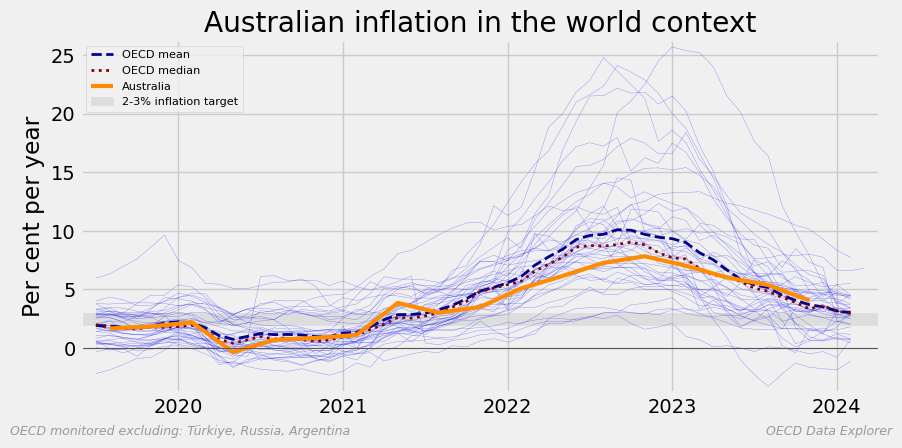

In [31]:
def plot_world_inflation():
    "Plot World Inflation."

    kwargs = {
        "title": "Australian inflation in the world context",
        "ylabel": "Per cent per year",
        "lfooter": f'OECD monitored excluding: {", ".join(EXCLUDE)}',
        "axhspan": TARGET,
    }

    plot_world(
        annual_inflation,
        exclusions=EXCLUDE,
        **kwargs,
    )


plot_world_inflation()

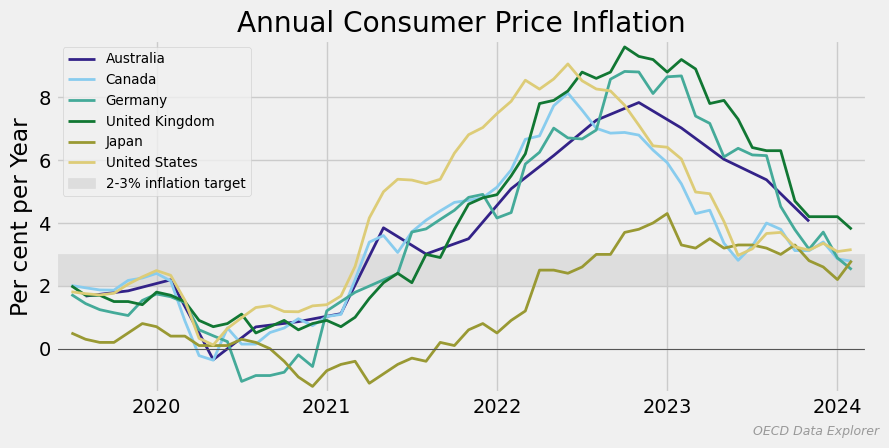

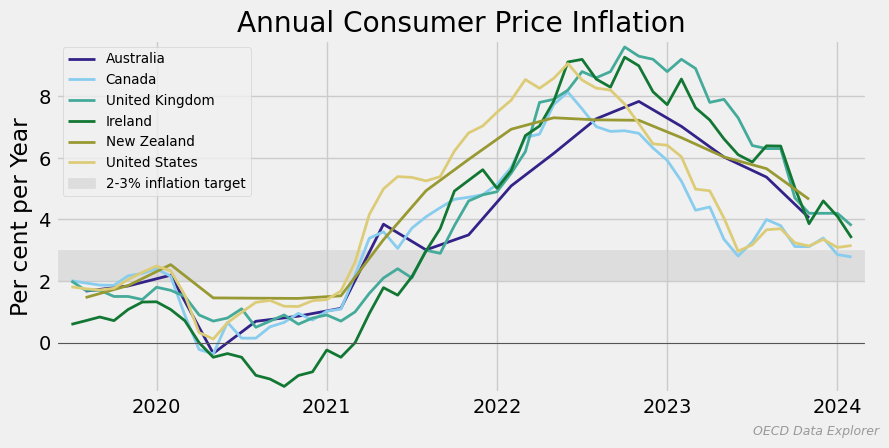

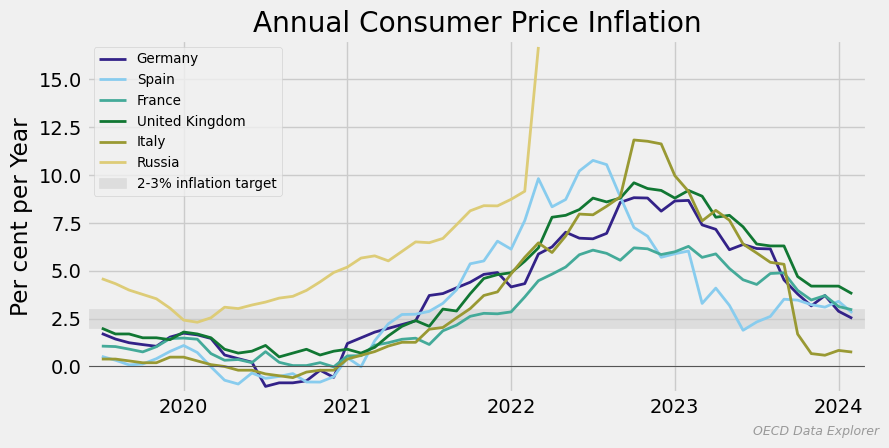

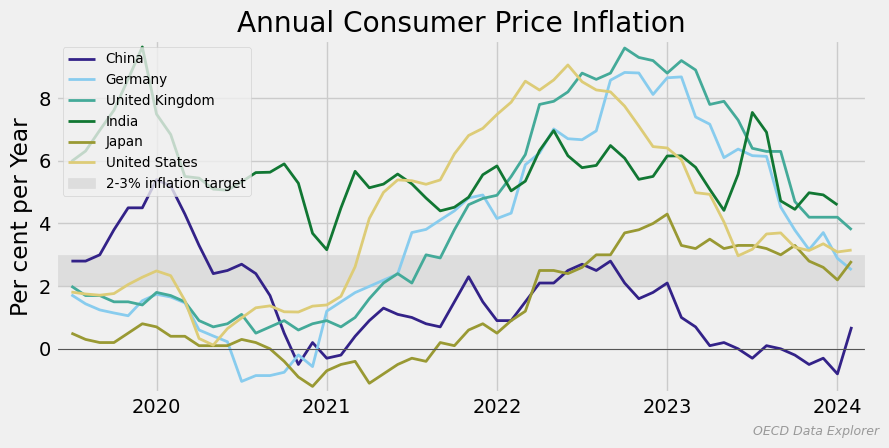

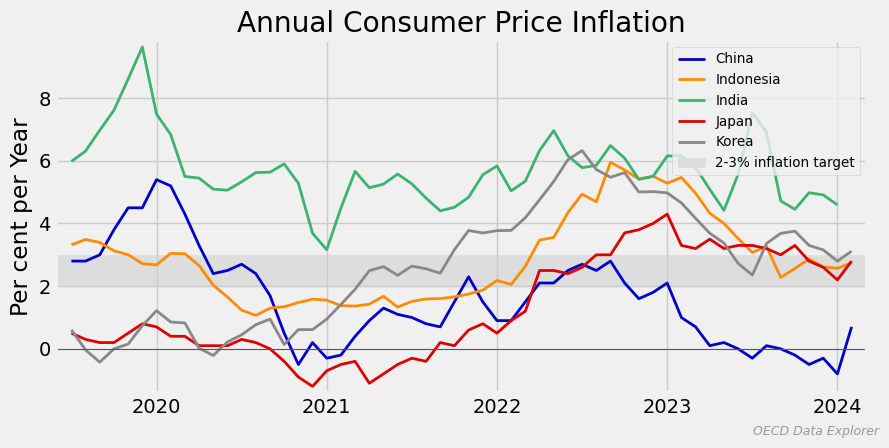

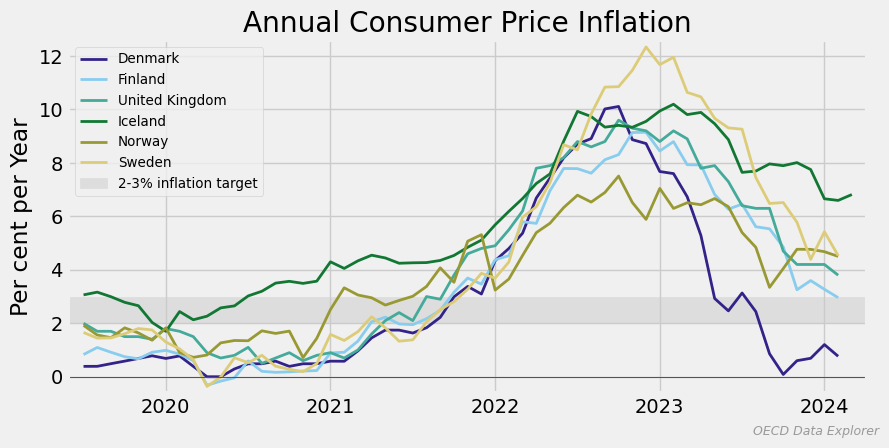

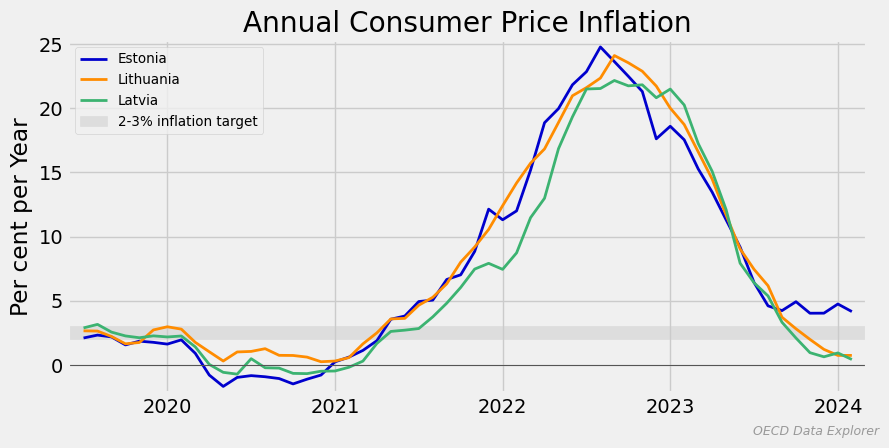

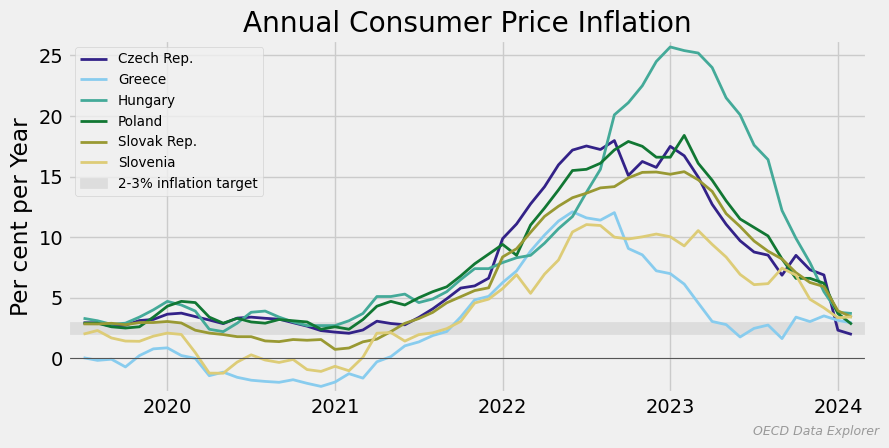

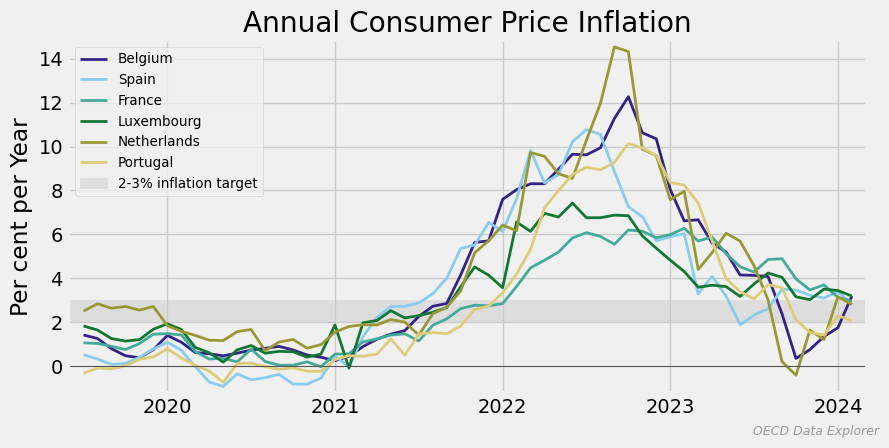

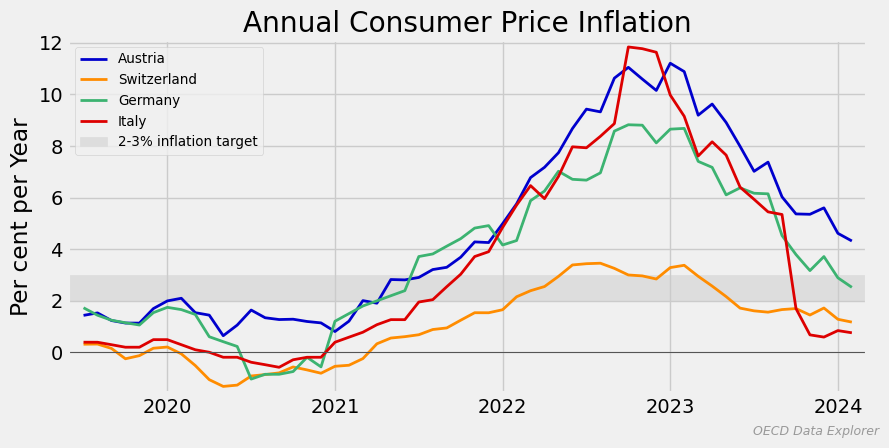

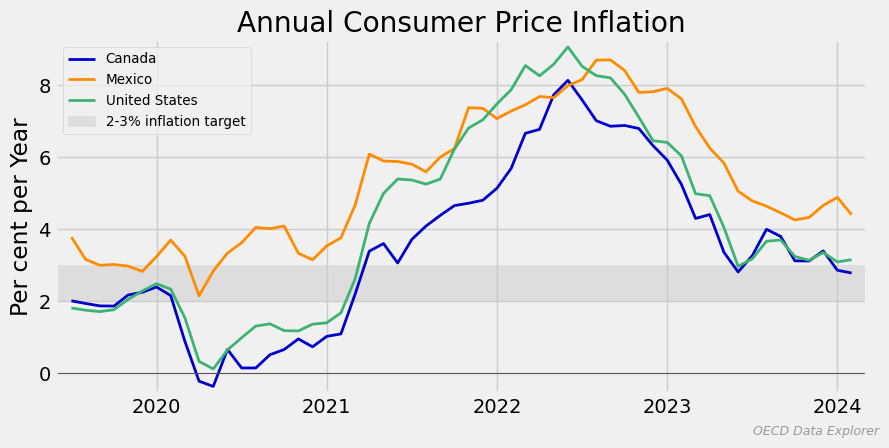

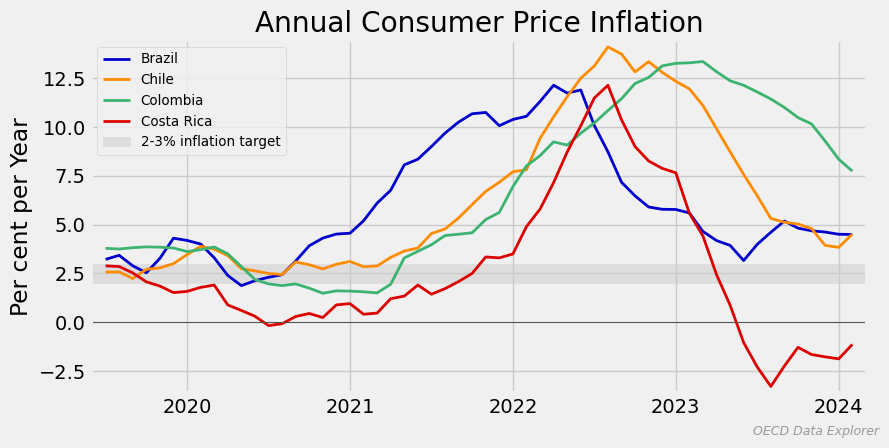

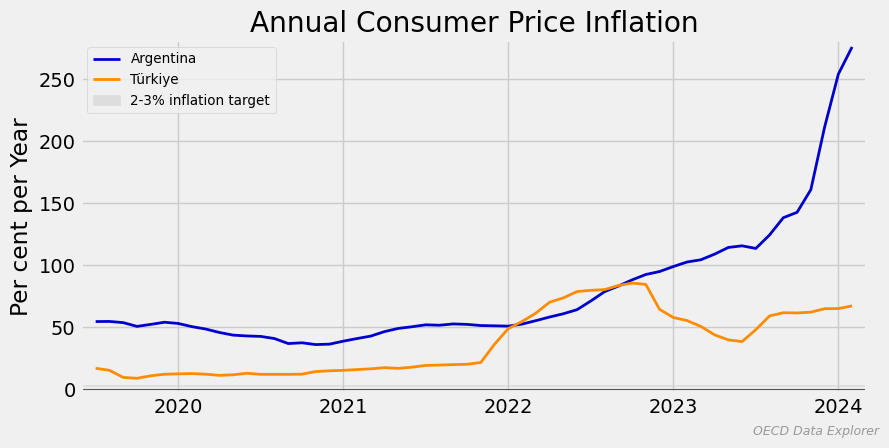

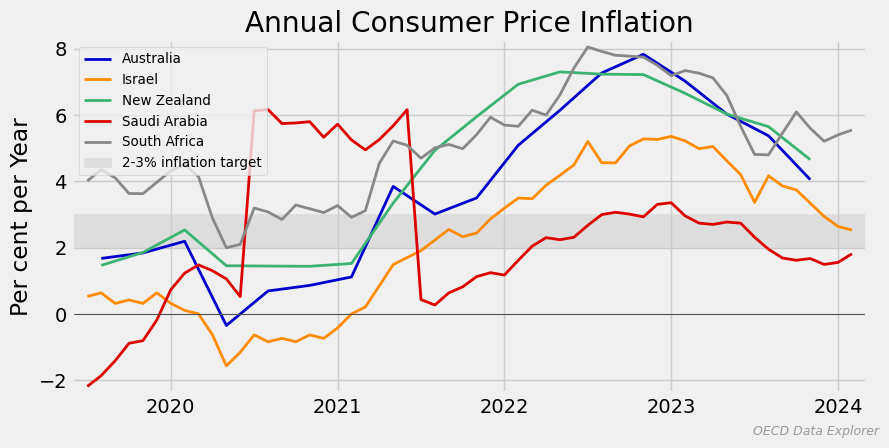

In [32]:
def plot_annual_inflation(data: pd.DataFrame):
    "Plot annual inflation."

    kwargs = {
        "title": "Annual Consumer Price Inflation",
        "ylabel": "Per cent per Year",
        "axhspan": TARGET,
    }
    plot_annual(data, **kwargs)


plot_annual_inflation(annual_inflation)

## Finished

In [33]:
%reload_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed Apr 03 2024 09:23:45

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

matplotlib: 3.8.3
numpy     : 1.26.4
pandas    : 2.2.1

Watermark: 2.4.3

